# Project on frame buckling

1. Define a new class `Frame_Buckling` as a child of the class `LinearFrame` provided in `frame.py`. Add in this class methods to extract the **normal stress** $\bar N_0$ in each bar and to assemble the *geometric stiffness* $G$.


2. Solve the buckling problem for a simply supported straight beam using the `Frame_Buckling` class and compare with the analytical solution (see e.g. cours/TD 3A103) when using different number of element. 



3. Solve the buckling problem for the frame of the Exercise 2 in the notebook 02-LinearFrame. Compare with the experimental findings on the first buckling load and mode. Represent the first 2 buckling modes.



4. Propose an improved geometry of the frame  of the Exercise 2 in the notebook 02-LinearFrame to increase the buckling load. Support your proposal with numerical results.


(For classes in `python` you can look https://en.wikibooks.org/wiki/A_Beginner%27s_Python_Tutorial/Classes, for example)

In [2]:
%matplotlib inline  
from sympy.interactive import printing
printing.init_printing()
from frame import *
import sympy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg

In [3]:
class Frame_Buckling(LinearFrame):

    def N_local_stress(self,element):

        """
        Returns the normal forces of an element.
        """
        Ke= self.K_local()
        Ue= self.U_e_local_coord(element)
        F=Ke*Ue
        N_local = F[3]
        return N_local
    
    def N_local_stress_tot(self):

        """
        Returns the normal force of all elements.
        """
        Ns=[self.N_local_stress(e)for e in range (self.nelements)]
        return Ns
    
    def G_local(self):
        """
        Returns the global geometric stiffness matrix
        """
        L = sp.Symbol('L')
        s = sp.Symbol('s')
        S=self.S()
        Ge=sp.Matrix([[sp.integrate(S[1,i_local].diff(s)*S[1,j_local].diff(s),(s,0,L) )for i_local in range(6)] for j_local in range(6)]) 
        return Ge
    
    def G_local_rotated(self):
        """
        Gives the analytical expression the local geometric stiffness matrix in the global coordinate system 
        as a function of the orientation angle alpha
        """
        alpha = sp.Symbol("alpha")
        R = self.rotation_matrix(alpha)
        Ge = R.transpose()*self.G_local()*R
        return Ge
    
    def assemble_G(self):
        """
        Returns the global stiffness matrix
        """
        Ge = self.G_local_rotated()
        G = np.zeros([self.ndof,self.ndof])
        N0=self.N_local_stress_tot()
        for e in range(self.nelements):
            Gen = -N0[e].subs({'EI': self.EI[e], 'ES': self.ES[e], 'L': self.Ls[e], 'alpha': self.angles[e]})*Ge.subs({'EI': self.EI[e], 'ES': self.ES[e], 'L': self.Ls[e], 'alpha': self.angles[e]})
            for i_local in range(6):
                for j_local in range(6):
                    G[self.dof_map(e, i_local),self.dof_map(e, j_local)] += Gen[i_local,j_local]
        return G
    
    def bc_apply_G(self,G,blocked_dof,bc_values):
        for (dof) in enumerate(blocked_dof): 
            Gbc = G 
            Gbc[dof, :] = 0
            Gbc[:, dof] = 0
            Gbc[dof, dof] = 1
        return Gbc

In [4]:
def full_power_method(A, niterations_max=50, tol=1e-15):
    xn = np.zeros((len(A), niterations_max+1))
    xn[:, 0] = np.ones((len(A),)) + 1e-7*np.random.rand(len(A))
    rn = np.ones((niterations_max+1,))
    for k in range(niterations_max):
        xn[:,k] = xn[:,k] / np.linalg.norm(xn[:,k])
        xn[:,k+1] = np.dot(A, xn[:,k])
        rn[k+1] = np.sum(xn[:,k+1])/np.sum(xn[:,k])
        if (abs(rn[k+1]-rn[k]) < tol):
            break
    if k < niterations_max:
        rn[k+2:] = rn[k+1] # This ensures the later values are set to something sensible.
    return (rn[k+1], rn, xn[:,k+1]/ np.linalg.norm(xn[:,k+1]))

def inverse_power_method(A, niterations_max=50, tol=1e-15):
    xn = np.zeros((len(A), niterations_max+1))
    xn[:, 0] = np.ones((len(A),)) + 1e-7*np.random.rand(len(A))
    rn = np.ones((niterations_max+1,))
    for k in range(niterations_max):
        xn[:,k] = xn[:,k] / np.linalg.norm(xn[:,k])
        xn[:,k+1] = np.linalg.solve(A, xn[:,k])
        rn[k+1] = np.sum(xn[:,k+1])/np.sum(xn[:,k])
        if (abs(rn[k+1]-rn[k]) < tol):
            break
    if k < niterations_max:
        rn[k+2:] = rn[k+1] # This ensures the later values are set to something sensible.
    return (1.0/rn[k+1], 1.0/rn, xn[:,k+1]/ np.linalg.norm(xn[:,k+1]))

In [5]:
E=1.3 #en MPa
h=7.5 #en mm
b=20. #en mm
Lx=55. #en mm
Lyh=60. #en mm
Lyb=45. #en mm
I=b*(h**3)/12 #en mm^4
S=b*h  #en mm^2
eps=10**(-3)
g=9.81 #en m.s^(-2)
m=1 #en kg

Frame with
4 elements
5 nodes
15 dofs


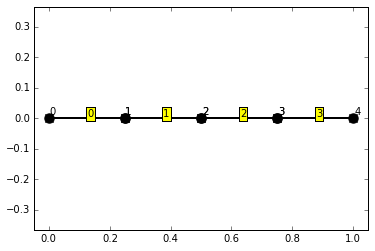

In [182]:
n_elements = 4
xnodes = np.linspace(0,1,n_elements + 1)
ynodes = np.linspace(0,0,n_elements + 1)
nodes = np.array([xnodes,ynodes]).transpose()
n_nodes = xnodes.size
elements=np.array([[0,1],[1,2],[2,3],[3,4]])

frame= Frame_Buckling(nodes,elements)
frame.plot_with_label()

In [183]:
ne = frame.nelements
ndof = frame.ndof
EI = np.ones(ne)*E*I
ES = np.ones(ne)*E*S
f_x = 0*np.ones(7)
f_y = 0*np.ones(7)
frame.set_distributed_loads(f_x, f_y)
frame.set_stiffness(EI, ES)
blocked_dof = np.array([0, 1, ndof-2])
bc_values = np.array([0, 0, 0])

In [184]:
K = frame.assemble_K()
F=frame.assemble_F()
F[12]=F[12]-.5*EI[0]*np.pi**2
Kbc, Fbc = frame.bc_apply(K, F, blocked_dof, bc_values)
Usol = np.linalg.solve(Kbc,Fbc)
Usol

array([  0.        ,   0.        ,   0.        ,  -5.78297133,
         0.        ,   0.        , -11.56594266,   0.        ,
         0.        , -17.34891399,   0.        ,   0.        ,
       -23.13188532,   0.        ,   0.        ])

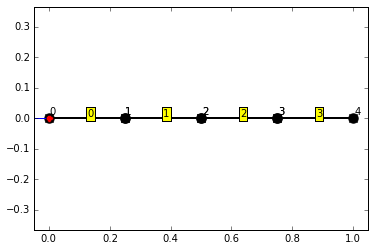

In [185]:
frame.set_displacement(Usol)
frame.plot_with_label()
frame.plot_displaced()

In [186]:
Gbc=frame.assemble_G()
G=frame.bc_apply_G(Gbc,blocked_dof,bc_values)

In [187]:
Ks = sparse.csr_matrix(K)
Gs = sparse.csr_matrix(G)
val, vect = linalg.eigsh(Ks, 5, Gs, which = 'LA', sigma = 1.6)
print(val)

[  1.90990929   8.06320329  19.46915997  42.88231458  74.18298925]


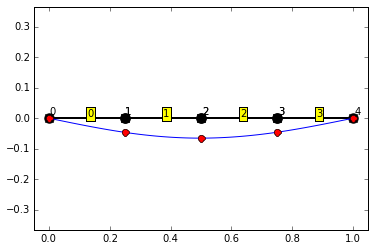

In [188]:
frame.set_displacement(10*vect[:,0])
frame.plot_with_label()
frame.plot_displaced()

## Essai sur exercice 2

In [98]:
E=1.3 #en MPa
h=7.5 #en mm
b=20. #en mm
Lx=55. #en mm
Lyh=60. #en mm
Lyb=45. #en mm
I=b*(h**3)/12 #en mm^4
S=b*h  #en mm^2
eps=10**(-3)
g=9.81 #en m.s^(-2)
m=0.05 #en kg

Frame with
7 elements
7 nodes
21 dofs


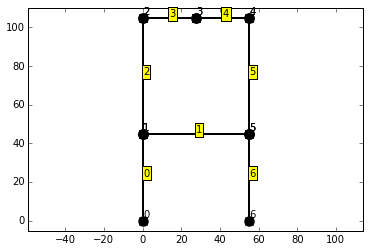

In [190]:
nodes= np.array([[0.,0.],[0.,Lyb],[0.,Lyh+Lyb],[Lx/2,Lyh+Lyb],[Lx,Lyh+Lyb],[Lx,Lyb],[Lx,0.]])
elements=np.array([[0,1],[1,5],[1,2],[2,3],[3,4],[4,5],[5,6]])

frame= Frame_Buckling(nodes,elements)
frame.plot_with_label()

In [301]:
ne = frame.nelements
ndof = frame.ndof
EI = np.ones(ne)*E*I
ES = np.ones(ne)*E*S
EI[1]=100*E*I;EI[3]=100*E*I;EI[4]=100*E*I
ES[1]=100*E*S;ES[3]=100*E*S;ES[4]=100*E*S
f_x = 0*np.ones(7)
f_y = 0*np.ones(7)
frame.set_distributed_loads(f_x, f_y)
frame.set_stiffness(EI, ES)
blocked_dof = np.array([0, 1, 2, ndof-3, ndof-2, ndof-1])
bc_values = np.array([0, 0, 0, 0, 0, 0])

In [361]:
K = frame.assemble_K()
F=frame.assemble_F()
F[10]=F[10]-.5*EI[0]*np.pi**2/(Lyb+Lyh)**2
F[10]=F[10]-1
Kbc, Fbc = frame.bc_apply(K, F, blocked_dof, bc_values)
Usol = np.linalg.solve(Kbc,Fbc)
Usol

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -6.18976176e-06,  -1.62592545e-01,   2.51615522e-05,
         6.09470934e-06,  -3.79382604e-01,  -2.86238120e-03,
        -1.13965114e-15,  -4.32099029e-01,   1.77002455e-17,
        -6.09470934e-06,  -3.79382604e-01,   2.86238120e-03,
         6.18976176e-06,  -1.62592545e-01,  -2.51615522e-05,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [362]:
frame.set_displacement(Usol)

In [363]:
Ge=frame.N_local_stress_tot()

In [364]:
Gbc=frame.assemble_G()
G=frame.bc_apply_G(Gbc,blocked_dof,bc_values)

In [365]:
Ks = sparse.csr_matrix(K)
Gs = sparse.csr_matrix(G)
val, vect = linalg.eigsh(Ks, 3, Gs, which = 'LA', sigma = 3.)
print(val)
print(vect[:,0])


[   3.24561362    4.69552602  301.24173277]
[ -1.47698107e-17  -1.28957217e-17  -1.26876421e-17   9.68970660e-02
  -4.08661851e-01   1.00343494e-02  -5.43587382e+00  -4.79404354e-01
   1.25098671e-02  -5.43587504e+00  -1.52925338e-01   1.15508637e-02
  -5.43587627e+00   1.73317475e-01   1.24926887e-02   9.68151746e-02
   1.02574972e-01   9.73972341e-03   5.79754728e-17   2.41984727e-18
  -2.77574986e-18]


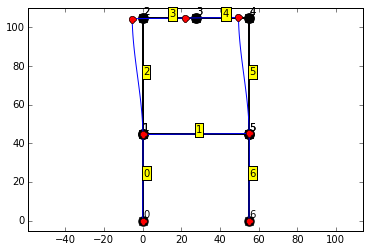

In [367]:
frame.set_displacement(1*vect[:,0])
frame.plot_with_label()
frame.plot_displaced()

# Essai sur d'autres structures

Structure avec des piliers au milieu :

Frame with
11 elements
8 nodes
24 dofs


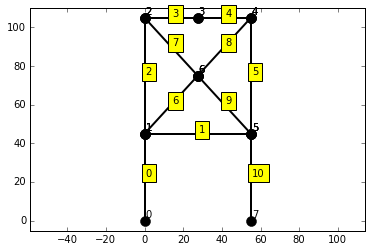

In [63]:
nodes= np.array([[0.,0.],[0.,Lyb],[0.,Lyh+Lyb],[Lx/2,Lyh+Lyb],[Lx,Lyh+Lyb],[Lx,Lyb],[Lx/2,Lyh/2+Lyb],[Lx,0.]])
elements=np.array([[0,1],[1,5],[1,2],[2,3],[3,4],[4,5],[1,6],[2,6],[4,6],[5,6],[5,7]])

frame= Frame_Buckling(nodes,elements)
frame.plot_with_label()

In [64]:
ne = frame.nelements
ndof = frame.ndof
EI = np.ones(ne)*E*I
ES = np.ones(ne)*E*S
EI[1]=100*E*I;EI[3]=100*E*I;EI[4]=100*E*I
ES[1]=100*E*S;ES[3]=100*E*S;ES[4]=100*E*S
f_x = 0*np.ones(ne)
f_y = 0*np.ones(ne)
frame.set_distributed_loads(f_x, f_y)
frame.set_stiffness(EI, ES)
blocked_dof = np.array([0, 1, 2, ndof-3, ndof-2, ndof-1])
bc_values = np.array([0, 0, 0, 0, 0, 0])

In [77]:
K = frame.assemble_K()
F=frame.assemble_F()
F[10]=F[10]-.5*EI[0]*np.pi**2/(Lyb+Lyh)**2
F[10]=F[10]-1
Kbc, Fbc = frame.bc_apply(K, F, blocked_dof, bc_values)
Usol = np.linalg.solve(Kbc,Fbc)

In [78]:
frame.set_displacement(Usol)

In [79]:
Gbc=frame.assemble_G()
G=frame.bc_apply_G(Gbc,blocked_dof,bc_values)

In [93]:
Ks = sparse.csr_matrix(K)
Gs = sparse.csr_matrix(G)
val, vect = linalg.eigsh(Ks, 5, Gs, which = 'LA', sigma =4.)
print(val)
print(vect[:,0])

[ 4.25158067  4.49181215  4.51820698  4.52708885  4.53040051]
[  7.18833290e-17   1.24332155e-16   7.53974563e-17   3.32981106e-02
  -9.82341486e-01   1.80502745e-02  -1.12897976e+00  -1.00360009e+00
   1.89717946e-02  -1.12898116e+00  -4.82402782e-01   1.89401349e-02
  -1.12898255e+00   3.84737025e-02   1.89484508e-02   3.32022462e-02
   1.87906736e-02   1.80897350e-02  -5.35225429e-01  -4.83516447e-01
   1.96053928e-02   5.72481779e-17   5.48267595e-17   2.52557067e-17]


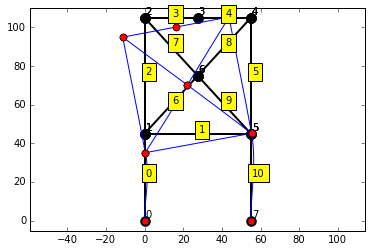

In [94]:
frame.set_displacement(10*vect[:,0])
frame.plot_with_label()
frame.plot_displaced()

Structure avec deux forces et sans étage renforcé :

Frame with
7 elements
7 nodes
21 dofs


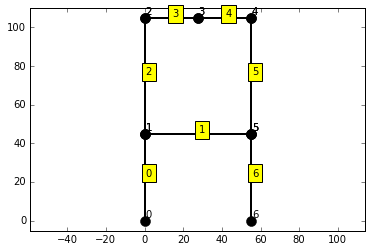

In [97]:
nodes= np.array([[0.,0.],[0.,Lyb],[0.,Lyh+Lyb],[Lx/2,Lyh+Lyb],[Lx,Lyh+Lyb],[Lx,Lyb],[Lx,0.]])
elements=np.array([[0,1],[1,5],[1,2],[2,3],[3,4],[4,5],[5,6]])

frame= Frame_Buckling(nodes,elements)
frame.plot_with_label()

In [144]:
ne = frame.nelements
ndof = frame.ndof
EI = np.ones(ne)*E*I
ES = np.ones(ne)*E*S
f_x = 0*np.ones(7)
f_y = 0*np.ones(7)
frame.set_distributed_loads(f_x, f_y)
frame.set_stiffness(EI, ES)
blocked_dof = np.array([0, 1, 2, ndof-3, ndof-2, ndof-1])
bc_values = np.array([0, 0, 0, 0, 0, 0])

In [145]:
K = frame.assemble_K()
F=frame.assemble_F()
F[7]=F[7]-.5*EI[0]*np.pi**2/(Lyb+Lyh)**2
F[13]=F[13]-.5*EI[0]*np.pi**2/(Lyb+Lyh)**2
F[7]=F[7]-1
F[13]=F[13]-1
Kbc, Fbc = frame.bc_apply(K, F, blocked_dof, bc_values)
Usol = np.linalg.solve(Kbc,Fbc)
Usol

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.03952803e-16,  -3.25185089e-01,  -3.83675681e-18,
         4.45871327e-16,  -7.58765208e-01,  -1.16792517e-17,
         4.32961285e-16,  -7.58765208e-01,  -5.27719425e-18,
         4.19222719e-16,  -7.58765208e-01,   3.71523449e-18,
         1.06616732e-16,  -3.25185089e-01,  -3.85983490e-18,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [146]:
frame.set_displacement(Usol)

In [147]:
Gbc=frame.assemble_G()
G=frame.bc_apply_G(Gbc,blocked_dof,bc_values)

In [148]:
Ks = sparse.csr_matrix(K)
Gs = sparse.csr_matrix(G)
val, vect = linalg.eigsh(Ks, 6, Gs, which = 'LA', sigma =1.2)
print(val)
print(vect[:,0])

[   4.39733264    6.32270475   10.92124672   16.64367193   69.9660391
  208.59894207]
[  5.55111512e-17  -2.77555756e-17  -4.16333634e-17   2.23966965e-03
   9.95095128e-01  -3.27765291e-03  -2.30818353e-01   9.88470972e-01
  -1.49600036e-02  -2.31064303e-01   4.59346779e-01  -2.05531523e-02
  -2.31310253e-01   2.13207873e-02  -8.33467992e-03   8.20870636e-03
   1.46966307e-02  -9.12085382e-03   3.33066907e-16   1.11022302e-16
   5.55111512e-17]


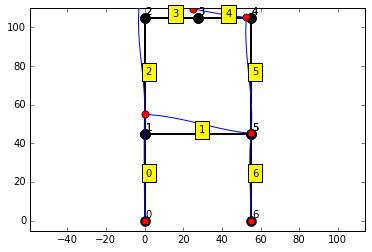

In [149]:
frame.set_displacement(10*vect[:,0])
frame.plot_with_label()
frame.plot_displaced()